In [2]:
import pandas as pd
import os
import opendatasets as od

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
import cv2 as cv

### DATA LOADING AND UNDERSTANDING

In [5]:
dataset = 'https://www.kaggle.com/datasets/anshtanwar/jellyfish-types'

In [6]:
#od.download(dataset)

In [7]:
data_directory = 'jellyfish-types/'

In [8]:
type_folders = os.listdir(data_directory)

There are 7 folders. 6 folders for each category of the target variable. 1 folder that splits the images into training, testing, and validation folders, but I'll be manually splitting the data using the images in the other folders. The project calls for no more than 5 target variable categories, so I'll be using each jellyfish type folder other than Train_Test_Valid and mauve_stinger_jellyfish.

In [9]:
type_folders

['compass_jellyfish',
 'Moon_jellyfish',
 'blue_jellyfish',
 'lions_mane_jellyfish',
 'mauve_stinger_jellyfish',
 'barrel_jellyfish',
 'Train_Test_Valid']

In [10]:
compass_dir = data_directory + type_folders[0] + '/'
moon_dir = data_directory + type_folders[1] + '/'
blue_dir = data_directory + type_folders[2] + '/'
lions_mane_dir = data_directory + type_folders[3] + '/'
barrel_dir = data_directory + type_folders[5] + '/'

In [11]:
import random as rnd

In [12]:
len(os.listdir(compass_dir)), len(os.listdir(moon_dir)), len(os.listdir(blue_dir)), len(os.listdir(lions_mane_dir)), len(os.listdir(barrel_dir))

(150, 150, 148, 148, 150)

Each folder holds 150 images, but the assignment calls for no more 100. I've selected 100 at random from each folder. Before I do that, I'm going to check each folder for corrupt images.

##### CHECKING FOR CORRUPT IMAGES

In [13]:
compass_imgs = os.listdir(compass_dir)
moon_imgs = os.listdir(moon_dir)
blue_imgs = os.listdir(blue_dir)
lions_mane_imgs = os.listdir(lions_mane_dir)
barrel_imgs = os.listdir(barrel_dir)

In [14]:
compass_fnames = [compass_dir + compass_imgs[i] for i in range(len(compass_imgs))]
moon_fnames = [moon_dir + moon_imgs[i] for i in range(len(moon_imgs))]
blue_fnames = [blue_dir + blue_imgs[i] for i in range(len(blue_imgs))]
lions_mane_fnames = [lions_mane_dir + lions_mane_imgs[i] for i in range(len(lions_mane_imgs))]
barrel_fnames = [barrel_dir + barrel_imgs[i] for i in range(len(barrel_imgs))]

In [15]:
#def jfif(fnames):
#    num_skipped = 0
#    indexes = []
#    for i in range(len(fnames)):
#        try:
#            fobj = open(fnames[i], 'rb')
#            is_jfif = b"JFIF" in fobj.peek(10)
#        finally:
#            fobj.close()
#        
#        if not is_jfif:
#            num_skipped += 1
#            os.remove(fnames[i])
#            indexes.append(i)
#    return num_skipped, indexes

In [16]:
#compass_skipped, compass_i = jfif(compass_fnames)
#moon_skipped, moon_i = jfif(moon_fnames)
#blue_skipped, blue_i = jfif(blue_fnames)
#lions_mane_skipped, lions_mane_i = jfif(lions_mane_fnames)
#barrel_skipped, barrel_i = jfif(barrel_fnames)

In [17]:
#compass_skipped, moon_skipped, blue_skipped, lions_mane_skipped, barrel_skipped

In [18]:
#blue_i, lions_mane_i

There were two corrupt images in the blue jellyfish folder and two in the lions mane folder. They were removed because they didn't contain JFIF. These folders now have 148 images in them.

In [19]:
def resize(img, size):
    return cv.resize(img, size)

def get_image_data(fnames):
    image_data = []
    for i in range(len(fnames)):
        data = resize(cv.imread(fnames[i]), (224, 224))
        image_data.append(data)
    return image_data

def get_dimensions(jellyfish):
    heights, widths, channels = [], [], []
    for i in range(len(jellyfish)):
        img = jellyfish[i]
        h, w, c = img.shape
        heights.append(h)
        widths.append(w)
        channels.append(c)
    return np.asarray(heights), np.asarray(widths), np.asarray(channels)

def show_images(jellyfish, count):
    num_cols = len(jellyfish)
    indexes = [i for i in range(100)]
    fig, axs = plt.subplots(count, num_cols)
    fig.set_figheight(30)
    fig.set_figwidth(30)
    for i in range(count):
        for j in range(num_cols):
            axs[i][j].imshow(jellyfish[j][rnd.choice(indexes)])
            
    plt.show()
    
def get_pixel_means(image_data):
    means = []
    for i in range(len(image_data)):
        means.append(np.mean(np.mean(image_data[i], axis = 1), axis = 0))
    return means

def rgb_mean_outliers(r_means, g_means, b_means):
    rmean, gmean, bmean = r_means.mean(), g_means.mean(), b_means.mean()
    rstd, gstd, bstd = np.std(r_means), np.std(g_means), np.std(b_means)
    threshold = 3
    r_outliers, g_outliers, b_outliers = [], [], []
    r_indexes, g_indexes, b_indexes = [], [], []
    for i in range(len(r_means)):
        rz_score = (r_means[i] - rmean) / rstd
        gz_score = (g_means[i] - gmean) / gstd
        bz_score = (b_means[i] - bmean) / bstd
        if abs(rz_score > threshold):
            r_outliers.append(r_means[i])
            r_indexes.append(i)
        if abs(gz_score > threshold):
            g_outliers.append(g_means[i])
            g_indexes.append(i)
        if abs(bz_score > threshold):
            b_outliers.append(b_means[i])
            b_indexes.append(i)
    return r_outliers, r_indexes, g_outliers, g_indexes, b_outliers, b_indexes

def edge_density(fnames):
    densities = []
    for fname in fnames:
        img = cv.imread(fname, cv.IMREAD_GRAYSCALE)
        img = resize(img, (179, 179))
        assert img is not None, "file could not be read, check with os.path.exists()"
        edges = cv.Canny(img, 40, 140)
        edge_counts = np.sum(edges > 0)
        edge_density = edge_counts / (edges.shape[0] * edges.shape[1])
        densities.append(edge_density)
    return densities

def density_outliers(densities):
    mean = np.mean(densities)
    std = np.std(densities)
    threshold = 3
    outliers = []
    indexes = []
    for i in range(len(densities)):
        z_score = (densities[i] - mean) / std
        if abs(z_score) > threshold:
            outliers.append(densities[i])
            indexes.append(i)
    return outliers, indexes

##### GETTING 100 IMAGES FROM EACH OF THE 5 JELLYFISH TYPE FOLDERS

In [20]:
compass_imgs = rnd.sample(os.listdir(compass_dir), 100)
moon_imgs = rnd.sample(os.listdir(moon_dir), 100)
blue_imgs = rnd.sample(os.listdir(blue_dir), 100)
lions_mane_imgs = rnd.sample(os.listdir(lions_mane_dir), 100)
barrel_imgs = rnd.sample(os.listdir(barrel_dir), 100)

In [21]:
compass_fnames = [compass_dir + compass_imgs[i] for i in range(len(compass_imgs))]
moon_fnames = [moon_dir + moon_imgs[i] for i in range(len(moon_imgs))]
blue_fnames = [blue_dir + blue_imgs[i] for i in range(len(blue_imgs))]
lions_mane_fnames = [lions_mane_dir + lions_mane_imgs[i] for i in range(len(lions_mane_imgs))]
barrel_fnames = [barrel_dir + barrel_imgs[i] for i in range(len(barrel_imgs))]

In [22]:
def get_image_data(fnames):
    image_data = []
    for i in range(len(fnames)):
        data = resize(cv.imread(fnames[i]), (224, 224))
        image_data.append(data)
    return image_data

In [23]:
compass_image_data = get_image_data(compass_fnames)
moon_image_data = get_image_data(moon_fnames)
blue_image_data = get_image_data(blue_fnames)
lions_mane_image_data = get_image_data(lions_mane_fnames)
barrel_image_data = get_image_data(barrel_fnames)

In [24]:
def get_dimensions(jellyfish):
    heights, widths, channels = [], [], []
    for i in range(len(jellyfish)):
        img = jellyfish[i]
        h, w, c = img.shape
        heights.append(h)
        widths.append(w)
        channels.append(c)
    return np.asarray(heights), np.asarray(widths), np.asarray(channels)

In [25]:
compass_heights, compass_widths, compass_channels = get_dimensions(compass_image_data)
moon_heights, moon_widths, moon_channels = get_dimensions(moon_image_data)
blue_heights, blue_widths, blue_channels = get_dimensions(blue_image_data)
lions_mane_heights, lions_mane_widths, lions_mane_channels = get_dimensions(lions_mane_image_data)
barrel_heights, barrel_widths, barrel_channels = get_dimensions(barrel_image_data)

In [26]:
np.unique(barrel_heights), np.unique(barrel_widths)

(array([224]), array([224]))

##### VISUALIZING IMAGES WITH MATPLOTLIB

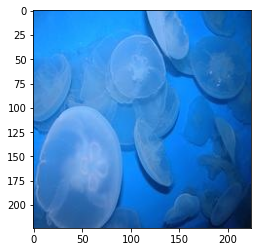

In [27]:
filename = moon_dir + moon_imgs[0]
pixels = plt.imread(filename)

plt.imshow(pixels)
plt.show()

##### RESIZING IMAGES WITH OPEN CV

In [28]:
import cv2 as cv

The images are either 179x179 or 224x224. I'm going to resize all of them to 224x224 with OpenCV's cv.resize.

(224, 224, 3)


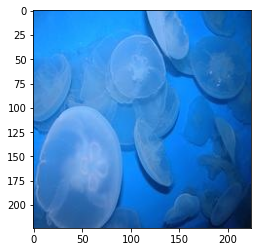

In [29]:
original = moon_fnames[0]
og_pixels = plt.imread(original)
print(og_pixels.shape)

plt.imshow(og_pixels)
plt.show()

(224, 224, 3)


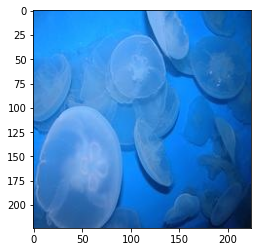

In [30]:
dim = (224, 224)
resized = cv.resize(og_pixels, dim)
print(resized.shape)

plt.imshow(resized)
plt.show()

Because they're square images, I don't need to worry about keeping the height:width proportion the same. It's 1:1.

In [31]:
def resize(img, size):
    return cv.resize(img, size)

##### FUNCTION TO GET PIXEL VALUES FOR EACH IMAGE  
  
Also resizes the images.

In [32]:
def get_image_data(fnames):
    image_data = []
    for i in range(len(fnames)):
        data = resize(cv.imread(fnames[i]), (224, 224))
        image_data.append(data)
    return image_data

In [33]:
compass_image_data = get_image_data(compass_fnames)
moon_image_data = get_image_data(moon_fnames)
blue_image_data = get_image_data(blue_fnames)
lions_mane_image_data = get_image_data(lions_mane_fnames)
barrel_image_data = get_image_data(barrel_fnames)

##### FUNCTION TO VISUALIZE IMAGES OF SPECIFIED COUNT AND TYPE IN A GRID

In [34]:
def show_images(jellyfish, count):
    num_cols = len(jellyfish)
    indexes = [i for i in range(100)]
    fig, axs = plt.subplots(count, num_cols)
    fig.set_figheight(30)
    fig.set_figwidth(30)
    for i in range(count):
        for j in range(num_cols):
            axs[i][j].imshow(jellyfish[j][rnd.choice(indexes)])
            
    plt.show()

The columns correspond with jellyfish type. The **first** column is **compass jellyfish**, the **second** is **moon**, the **third** is **blue**, the **fourth** is **lions mane**, and the **fifth** is **barrel**.

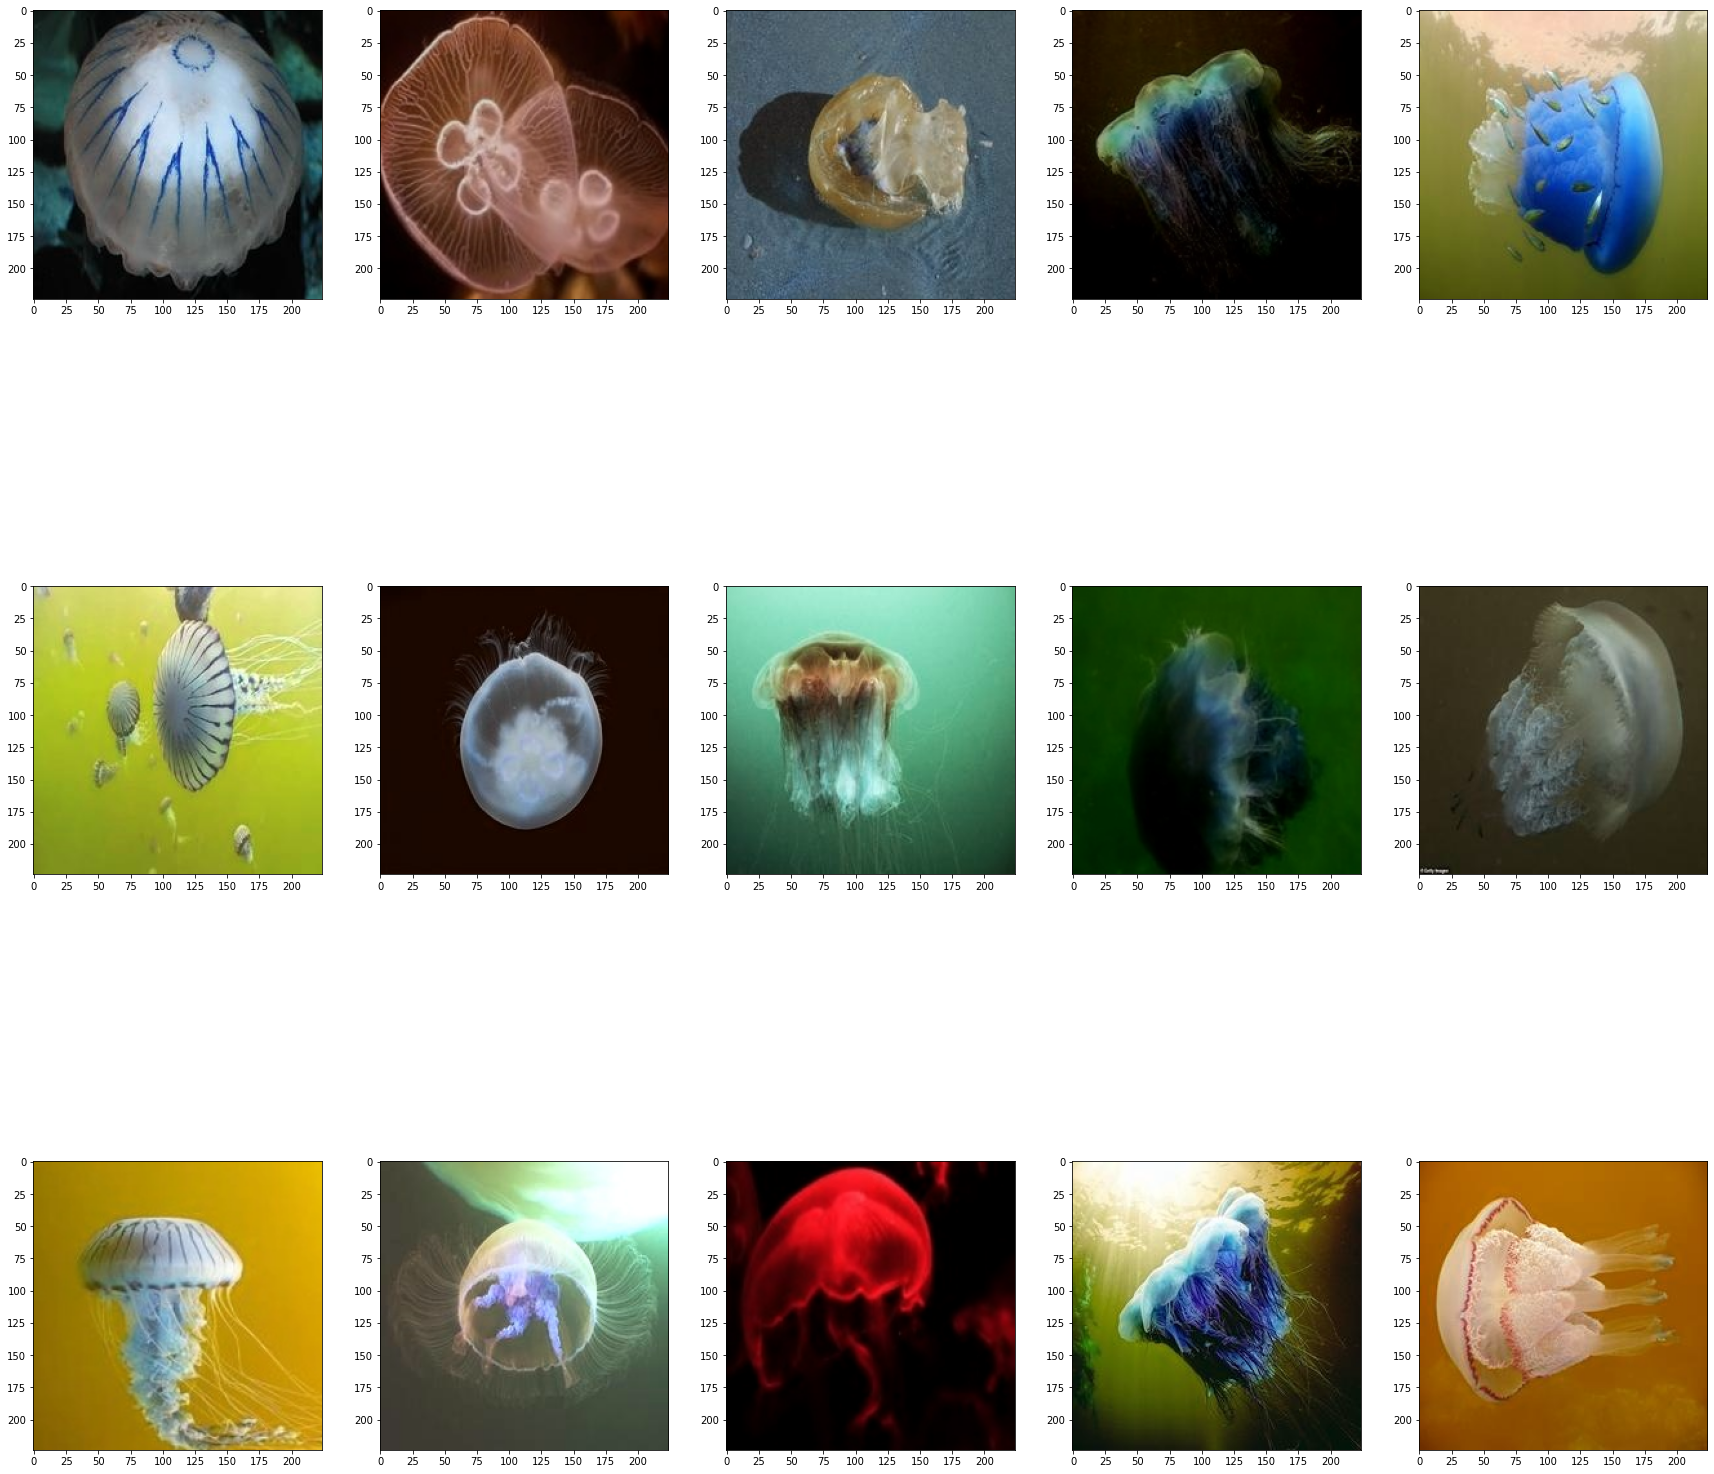

In [35]:
show_images([compass_image_data, moon_image_data, blue_image_data, lions_mane_image_data, barrel_image_data], 3)

##### RGB OUTLIERS  
  
The first method for finding images that needed to be removed was checking for JFIF above, but to be sure there aren't issues with other images, I'm going to check the pixel values for outliers and check the edge density of each image for outliers using Canny Edge Detection.

In [36]:
moon_image_data[0].shape

(224, 224, 3)

In [37]:
def get_pixel_means(image_data):
    means = []
    for i in range(len(image_data)):
        means.append(np.mean(np.mean(image_data[i], axis = 1), axis = 0))
    return means

In [38]:
compass_means = get_pixel_means(compass_image_data)
moon_means = get_pixel_means(moon_image_data)
blue_means = get_pixel_means(blue_image_data)
lions_mane_means = get_pixel_means(lions_mane_image_data)
barrel_means = get_pixel_means(barrel_image_data)

In [39]:
c_means_df = pd.DataFrame(compass_means, columns = ['r', 'g', 'b'])
m_means_df = pd.DataFrame(moon_means, columns = ['r', 'g', 'b'])
bl_means_df = pd.DataFrame(blue_means, columns = ['r', 'g', 'b'])
lm_means_df = pd.DataFrame(lions_mane_means, columns = ['r', 'g', 'b'])
ba_means_df = pd.DataFrame(barrel_means, columns = ['r', 'g', 'b'])

In [40]:
c_r_means = c_means_df['r']
c_g_means = c_means_df['g']
c_b_means = c_means_df['b']
m_r_means = m_means_df['r']
m_g_means = m_means_df['g']
m_b_means = m_means_df['b']
bl_r_means = bl_means_df['r']
bl_g_means = bl_means_df['g']
bl_b_means = bl_means_df['b']
lm_r_means = lm_means_df['r']
lm_g_means = lm_means_df['g']
lm_b_means = lm_means_df['b']
ba_r_means = ba_means_df['r']
ba_g_means = ba_means_df['g']
ba_b_means = ba_means_df['b']

In [41]:
def rgb_mean_outliers(r_means, g_means, b_means):
    rmean, gmean, bmean = r_means.mean(), g_means.mean(), b_means.mean()
    rstd, gstd, bstd = np.std(r_means), np.std(g_means), np.std(b_means)
    threshold = 3
    r_outliers, g_outliers, b_outliers = [], [], []
    r_indexes, g_indexes, b_indexes = [], [], []
    for i in range(len(r_means)):
        rz_score = (r_means[i] - rmean) / rstd
        gz_score = (g_means[i] - gmean) / gstd
        bz_score = (b_means[i] - bmean) / bstd
        if abs(rz_score > threshold):
            r_outliers.append(r_means[i])
            r_indexes.append(i)
        if abs(gz_score > threshold):
            g_outliers.append(g_means[i])
            g_indexes.append(i)
        if abs(bz_score > threshold):
            b_outliers.append(b_means[i])
            b_indexes.append(i)
    return r_outliers, r_indexes, g_outliers, g_indexes, b_outliers, b_indexes

In [42]:
cro, cri, cgo, cgi, cbo, cbi = rgb_mean_outliers(c_r_means, c_g_means, c_b_means)
mro, mri, mgo, mgi, mbo, mbi = rgb_mean_outliers(m_r_means, m_g_means, m_b_means)
blro, blri, blgo, blgi, blbo, blbi = rgb_mean_outliers(bl_r_means, bl_g_means, bl_b_means)
lmro, lmri, lmgo, lmgi, lmbo, lmbi = rgb_mean_outliers(lm_r_means, lm_g_means, lm_b_means)
baro, bari, bago, bagi, babo, babi = rgb_mean_outliers(ba_r_means, ba_g_means, ba_b_means)

In [43]:
cro, cri, cgo, cgi, cbo, cbi

([], [], [], [], [], [])

In [44]:
mro, mri, mgo, mgi, mbo, mbi

([213.187858737245],
 [40],
 [],
 [],
 [114.93624441964288, 114.17047991071423],
 [15, 69])

In [45]:
blro, blri, blgo, blgi, blbo, blbi

([], [], [], [], [], [])

In [46]:
lmro, lmri, lmgo, lmgi, lmbo, lmbi

([208.89945392219397], [41], [192.65278220663274], [38], [], [])

In [47]:
baro, bari, bago, bagi, babo, babi

([], [], [240.1607940051021], [12], [191.88803411989792], [12])

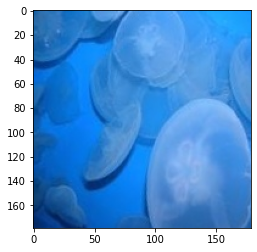

In [48]:
fname = moon_dir + moon_imgs[40]
pixels = plt.imread(fname)

plt.imshow(pixels)
plt.show()

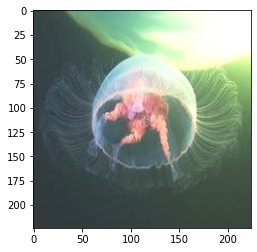

In [49]:
fname = moon_dir + moon_imgs[15]
pixels = plt.imread(fname)

plt.imshow(pixels)
plt.show()

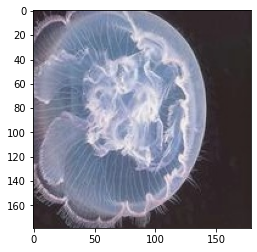

In [50]:
fname = moon_dir + moon_imgs[69]
pixels = plt.imread(fname)

plt.imshow(pixels)
plt.show()

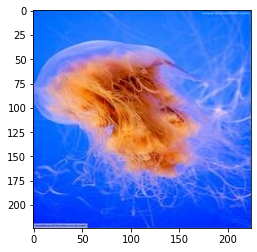

In [52]:
fname = lions_mane_dir + lions_mane_imgs[41]
pixels = plt.imread(fname)

plt.imshow(pixels)
plt.show()

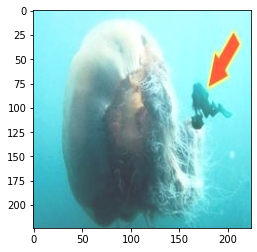

In [53]:
fname = lions_mane_dir + lions_mane_imgs[38]
pixels = plt.imread(fname)

plt.imshow(pixels)
plt.show()

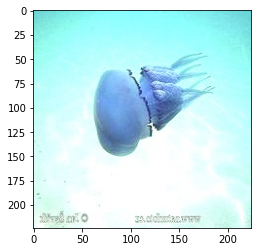

In [55]:
fname = barrel_dir + barrel_imgs[12]
pixels = plt.imread(fname)

plt.imshow(pixels)
plt.show()

##### Note on Duplicates  
  
Occasionally running the above code results in showing some images which are duplicate images, but with slight changes like being flipped or rotated. I considered using edge detection to find images with identical edge density because I thought that might allow me to find these images, but the code I tried didn't give me the results I was looking for. These instances seem to be rare, so they shouldn't have much of an effect, but if I have time I'll try some other ways to find these duplicate images and remove one of them.

##### Edge Detection

Canny Edge Detection finds the edges which make up the outline of the image. The result will be visualized below for one image to show what happens, but you also get an array matching the size of the image where values are either 0 (not an edge) or 255 (an edge). I will take the count of edges in the overall image and divide it by the total number of pixels. This will give me the edge density or the proportion of the overall image made up by edges. I'll then look for outliers and check those outlier images to be sure they aren't images that need to be removed.

The image is made grayscale to remove the rgb dimension and make the image two dimensional.

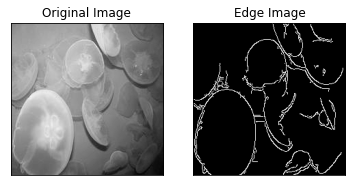

In [56]:
img = cv.imread(filename, cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
edges = cv.Canny(img,40,140)
 
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
 
plt.show()

In [57]:
edges

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [58]:
np.unique(edges)

array([  0, 255], dtype=uint8)

In [59]:
edge_counts = np.sum(edges > 0)

In [60]:
edge_density = edge_counts / (edges.shape[0] * edges.shape[1])

In [61]:
edge_density

0.054607780612244895

The edge density for the above example image is about 4% which is on the lower end.

In [62]:
compass_fnames = [compass_dir + compass_imgs[i] for i in range(len(compass_imgs))]
moon_fnames = [moon_dir + moon_imgs[i] for i in range(len(moon_imgs))]
blue_fnames = [blue_dir + blue_imgs[i] for i in range(len(blue_imgs))]
lions_mane_fnames = [lions_mane_dir + lions_mane_imgs[i] for i in range(len(lions_mane_imgs))]
barrel_fnames = [barrel_dir + barrel_imgs[i] for i in range(len(barrel_imgs))]

In [63]:
def edge_density(fnames):
    densities = []
    for fname in fnames:
        img = cv.imread(fname, cv.IMREAD_GRAYSCALE)
        img = resize(img, (224, 224))
        assert img is not None, "file could not be read, check with os.path.exists()"
        edges = cv.Canny(img, 40, 140)
        edge_counts = np.sum(edges > 0)
        edge_density = edge_counts / (edges.shape[0] * edges.shape[1])
        densities.append(edge_density)
    return densities

In [64]:
compass_densities = np.asarray(edge_density(compass_fnames))
moon_densities = np.asarray(edge_density(moon_fnames))
blue_densities = np.asarray(edge_density(blue_fnames))
lions_mane_densities = np.asarray(edge_density(lions_mane_fnames))
barrel_densities = np.asarray(edge_density(barrel_fnames))

In [65]:
def density_outliers(densities):
    mean = np.mean(densities)
    std = np.std(densities)
    threshold = 3
    outliers = []
    indexes = []
    for i in range(len(densities)):
        z_score = (densities[i] - mean) / std
        if abs(z_score) > threshold:
            outliers.append(densities[i])
            indexes.append(i)
    return outliers, indexes

In [66]:
compass_outliers, compass_indexes = density_outliers(compass_densities)
moon_outliers, moon_indexes = density_outliers(moon_densities)
blue_outliers, blue_indexes = density_outliers(blue_densities)
lions_mane_outliers, lions_mane_indexes = density_outliers(lions_mane_densities)
barrel_outliers, barrel_indexes = density_outliers(barrel_densities)

In [67]:
compass_outliers, compass_indexes

([0.3747409119897959, 0.37430245535714285], [4, 68])

In [68]:
moon_outliers, moon_indexes

([0.22245695153061223, 0.23001036352040816, 0.23016980229591838], [24, 46, 76])

In [69]:
blue_outliers, blue_indexes

([0.3356983418367347,
  0.33091517857142855,
  0.3319116709183674,
  0.34719786352040816],
 [17, 28, 60, 67])

In [70]:
lions_mane_outliers, lions_mane_indexes

([0.28553491709183676], [20])

In [71]:
barrel_outliers, barrel_indexes

([0.3459622130102041, 0.3308952487244898, 0.3461814413265306], [65, 89, 98])

Moon, Blue, and Barrel have edge density outliers. 1 for Moon, 3 for Blue, and 3 for Barrel.

### Using Edge Detection to Check for Duplicate or Slightly Altered Images

Didn't work. Thought the edge density would be the same for any image that had only been slightly altered (flipped or rotated, for example), but I'm not getting the results I expected. I may come back to this, but these images seem rare so it should be fine.

### GENERATING DATASET

In [115]:
y1 = ['compass'] * len(compass_fnames)
y2 = ['moon'] * len(moon_fnames)
y3 = ['blue'] * len(blue_fnames)
y4 = ['lions_mane'] * len(lions_mane_fnames)
y5 = ['barrel'] * len(barrel_fnames)

In [116]:
x = np.array(compass_image_data + moon_image_data + blue_image_data + lions_mane_image_data + barrel_image_data)

In [117]:
y = np.array(y1 + y2 + y3 + y4 + y5)

In [118]:
y = pd.DataFrame(y)

In [119]:
y

,0
0,compass
1,compass
2,compass
3,compass
4,compass
...,...
495,barrel
496,barrel
497,barrel
498,barrel


In [120]:
y = pd.get_dummies(y)

In [121]:
y

,0_barrel,0_blue,0_compass,0_lions_mane,0_moon
0,False,False,True,False,False
1,False,False,True,False,False
2,False,False,True,False,False
3,False,False,True,False,False
4,False,False,True,False,False
...,...,...,...,...,...
495,True,False,False,False,False
496,True,False,False,False,False
497,True,False,False,False,False
498,True,False,False,False,False


In [122]:
from sklearn.model_selection import train_test_split

In [123]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

### First Pre-Built Model From Keras

The first model I'm running uses ResNet50 as its base, has a Dense output layer with 5 neurons for the 5 classes in the target variable, and uses softmax activation. The next step will be adding 3 data augmentations and testing different numbers of layers and neurons to see how that changes the model's performance.

In [124]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet

##### ResNet50 Model 1

The first function builds my first model which is very basic. ResNet50 as its base and an output layer with 5 neurons (for 5 target variable classes). The output layer uses softmax activation because this is a multiclass classification problem.

In [125]:
def transfer_model1(input_shape):
    base = ResNet50(input_shape = input_shape, weights = 'imagenet',
                    include_top = False, pooling = 'avg')
    base.trainable = False
    
    inputs = Input(input_shape)
    x = resnet.preprocess_input(inputs)
    x = base(x)
    outputs = Dense(5, activation = 'softmax')(x)
    
    return Model(inputs, outputs, name = 'ResNetModel1')

In [126]:
model1 = transfer_model1(input_shape = (224, 224, 3))

In [127]:
model1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [128]:
history = model1.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10)

Epoch 1/10
11/11 [==============================] - 21s 2s/step - loss: 1.3055 - accuracy: 0.4886 - val_loss: 0.8163 - val_accuracy: 0.6800
Epoch 2/10
11/11 [==============================] - 21s 2s/step - loss: 0.5283 - accuracy: 0.8314 - val_loss: 0.5487 - val_accuracy: 0.7933
Epoch 3/10
11/11 [==============================] - 21s 2s/step - loss: 0.3156 - accuracy: 0.9029 - val_loss: 0.4390 - val_accuracy: 0.8267
Epoch 4/10
11/11 [==============================] - 22s 2s/step - loss: 0.2017 - accuracy: 0.9457 - val_loss: 0.3992 - val_accuracy: 0.8533
Epoch 5/10
11/11 [==============================] - 22s 2s/step - loss: 0.1402 - accuracy: 0.9743 - val_loss: 0.3631 - val_accuracy: 0.8600
Epoch 6/10
11/11 [==============================] - 22s 2s/step - loss: 0.1083 - accuracy: 0.9886 - val_loss: 0.3323 - val_accuracy: 0.8933
Epoch 7/10
11/11 [==============================] - 22s 2s/step - loss: 0.0847 - accuracy: 0.9943 - val_loss: 0.3188 - val_accuracy: 0.9133
Epoch 8/10
11/11 [==

For the first very basic model, at the 10th epoch, training accuracy is 100% and validation accuracy is 92%. The training accuracy was considerably worse than the validation accuracy for the first epoch. Before adding augmentation, I am going to add a dropout layer to this basic model and see how that affects things. I'll test three different dropout rates. Then I'll add augmentation and potentially some dense layers for a second model with ResNet50.

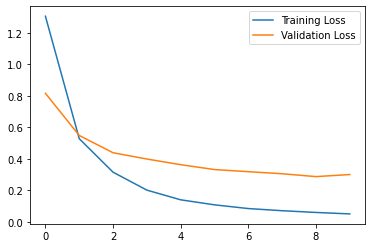

In [129]:
plt.plot(range(len(history.history['loss'])), history.history['loss'], label = 'Training Loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label = 'Validation Loss')
plt.legend()

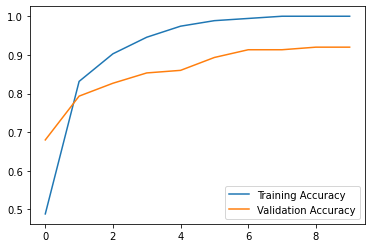

In [130]:
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label = 'Training Accuracy')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

The model performs well on both training and validation sets, but performance does diverge beginning with the second epoch. The accuracy curves diverge less after the fourth epoch and the loss curves diverge. The loss curves look like they are still diverging at the tenth epoch.

The model may be overfitting, so adding a dropout layer could help avoid that.

##### ResNet50 Model1 with Dropout Layer

In [131]:
def transfer_model2(input_shape):
    base = ResNet50(input_shape = input_shape, weights = 'imagenet',
                    include_top = False, pooling = 'avg')
    base.trainable = False
    
    inputs = Input(input_shape)
    x = resnet.preprocess_input(inputs)
    x = Dropout(0.2)(x)
    x = base(x)
    
    outputs = Dense(5, activation = 'softmax')(x)
    
    return Model(inputs, outputs, name = 'ResNetModel2')

In [132]:
model2 = transfer_model2(input_shape = (224, 224, 3))
model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [133]:
history2 = model2.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10)

Epoch 1/10
11/11 [==============================] - 22s 2s/step - loss: 1.8733 - accuracy: 0.3229 - val_loss: 1.4243 - val_accuracy: 0.3533
Epoch 2/10
11/11 [==============================] - 22s 2s/step - loss: 0.8941 - accuracy: 0.6486 - val_loss: 1.2240 - val_accuracy: 0.5467
Epoch 3/10
11/11 [==============================] - 22s 2s/step - loss: 0.5353 - accuracy: 0.8200 - val_loss: 0.9272 - val_accuracy: 0.6000
Epoch 4/10
11/11 [==============================] - 21s 2s/step - loss: 0.4039 - accuracy: 0.8686 - val_loss: 0.8061 - val_accuracy: 0.6933
Epoch 5/10
11/11 [==============================] - 21s 2s/step - loss: 0.3235 - accuracy: 0.8943 - val_loss: 0.7625 - val_accuracy: 0.7267
Epoch 6/10
11/11 [==============================] - 21s 2s/step - loss: 0.2638 - accuracy: 0.9229 - val_loss: 0.7219 - val_accuracy: 0.7333
Epoch 7/10
11/11 [==============================] - 21s 2s/step - loss: 0.2220 - accuracy: 0.9486 - val_loss: 0.6949 - val_accuracy: 0.7467
Epoch 8/10
11/11 [==

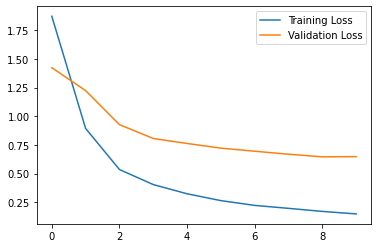

In [135]:
plt.plot(range(len(history2.history['loss'])), history2.history['loss'], label = 'Training Loss')
plt.plot(range(len(history2.history['val_loss'])), history2.history['val_loss'], label = 'Validation Loss')
plt.legend()

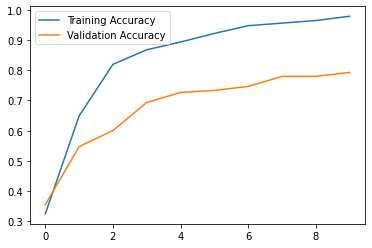

In [134]:
plt.plot(range(len(history2.history['accuracy'])), history2.history['accuracy'], label = 'Training Accuracy')
plt.plot(range(len(history2.history['val_accuracy'])), history2.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

The accuracy and loss for this model got worse for both training and validation sets, and training and validation performances diverges more for both loss and accuracy. A dropout rate of 0.2 really hurt validation performance especially. Training accuracy was 98% and validation accuracy was 79% at the tenth epoch. However, training and validation accuracy did start off much closer to one another. 32% and 35% respectively.

##### ResNet50 Model1 with Dropout Layer 2

In [136]:
def transfer_model3(input_shape):
    base = ResNet50(input_shape = input_shape, weights = 'imagenet',
                    include_top = False, pooling = 'avg')
    base.trainable = False
    
    inputs = Input(input_shape)
    x = resnet.preprocess_input(inputs)
    x = Dropout(0.3)(x)
    x = base(x)
    
    outputs = Dense(5, activation = 'softmax')(x)
    
    return Model(inputs, outputs, name = 'ResNetModel3')

In [137]:
model3 = transfer_model3(input_shape = (224, 224, 3))
model3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [138]:
history3 = model3.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10)

Epoch 1/10
11/11 [==============================] - 21s 2s/step - loss: 1.8877 - accuracy: 0.3543 - val_loss: 1.7104 - val_accuracy: 0.4533
Epoch 2/10
11/11 [==============================] - 19s 2s/step - loss: 0.9196 - accuracy: 0.6429 - val_loss: 1.3231 - val_accuracy: 0.5800
Epoch 3/10
11/11 [==============================] - 21s 2s/step - loss: 0.6245 - accuracy: 0.7886 - val_loss: 0.9385 - val_accuracy: 0.6667
Epoch 4/10
11/11 [==============================] - 21s 2s/step - loss: 0.4612 - accuracy: 0.8457 - val_loss: 0.9588 - val_accuracy: 0.6867
Epoch 5/10
11/11 [==============================] - 21s 2s/step - loss: 0.3826 - accuracy: 0.8857 - val_loss: 0.8724 - val_accuracy: 0.7133
Epoch 6/10
11/11 [==============================] - 21s 2s/step - loss: 0.3347 - accuracy: 0.8943 - val_loss: 0.7684 - val_accuracy: 0.7200
Epoch 7/10
11/11 [==============================] - 21s 2s/step - loss: 0.2798 - accuracy: 0.9171 - val_loss: 0.7533 - val_accuracy: 0.7067
Epoch 8/10
11/11 [==

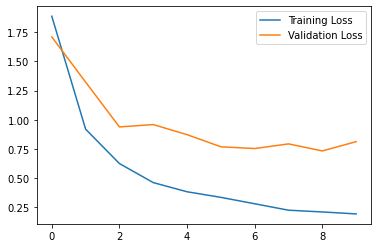

In [140]:
plt.plot(range(len(history3.history['loss'])), history3.history['loss'], label = 'Training Loss')
plt.plot(range(len(history3.history['val_loss'])), history3.history['val_loss'], label = 'Validation Loss')
plt.legend()

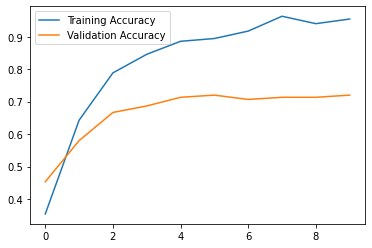

In [141]:
plt.plot(range(len(history3.history['accuracy'])), history3.history['accuracy'], label = 'Training Accuracy')
plt.plot(range(len(history3.history['val_accuracy'])), history3.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

Validation accuracy performed about the same with a dropout rate of 0.3 as with 0.2, but training accuracy performed slightly worse at 95%. There was a wider gap between starting accuracy with a 0.3 dropout rate than with 0.2.

##### ResNet50 Model1 with Dropout Layer 3

In [142]:
def transfer_model4(input_shape):
    base = ResNet50(input_shape = input_shape, weights = 'imagenet',
                    include_top = False, pooling = 'avg')
    base.trainable = False
    
    inputs = Input(input_shape)
    x = resnet.preprocess_input(inputs)
    x = Dropout(0.4)(x)
    x = base(x)
    
    outputs = Dense(5, activation = 'softmax')(x)
    
    return Model(inputs, outputs, name = 'ResNetModel4')

In [143]:
model4 = transfer_model4(input_shape = (224, 224, 3))
model4.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [144]:
history4 = model4.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10)

Epoch 1/10
11/11 [==============================] - 21s 2s/step - loss: 1.8999 - accuracy: 0.3029 - val_loss: 1.7503 - val_accuracy: 0.3267
Epoch 2/10
11/11 [==============================] - 19s 2s/step - loss: 0.9655 - accuracy: 0.6400 - val_loss: 1.1641 - val_accuracy: 0.5000
Epoch 3/10
11/11 [==============================] - 21s 2s/step - loss: 0.6463 - accuracy: 0.7829 - val_loss: 1.1407 - val_accuracy: 0.5267
Epoch 4/10
11/11 [==============================] - 21s 2s/step - loss: 0.5097 - accuracy: 0.8171 - val_loss: 0.8654 - val_accuracy: 0.6333
Epoch 5/10
11/11 [==============================] - 21s 2s/step - loss: 0.4361 - accuracy: 0.8600 - val_loss: 0.8719 - val_accuracy: 0.6267
Epoch 6/10
11/11 [==============================] - 21s 2s/step - loss: 0.3625 - accuracy: 0.8914 - val_loss: 0.8430 - val_accuracy: 0.6267
Epoch 7/10
11/11 [==============================] - 21s 2s/step - loss: 0.3334 - accuracy: 0.8829 - val_loss: 0.7702 - val_accuracy: 0.6733
Epoch 8/10
11/11 [==

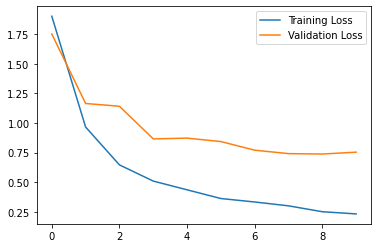

In [145]:
plt.plot(range(len(history4.history['loss'])), history4.history['loss'], label = 'Training Loss')
plt.plot(range(len(history4.history['val_loss'])), history4.history['val_loss'], label = 'Validation Loss')
plt.legend()

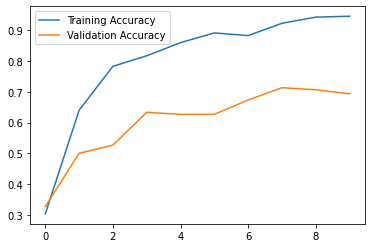

In [146]:
plt.plot(range(len(history4.history['accuracy'])), history4.history['accuracy'], label = 'Training Accuracy')
plt.plot(range(len(history4.history['val_accuracy'])), history4.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

The most divergence between training and validation so far. The worst final validation accuracy. Training and validation accuracy start very close to one another. At the tenth epoch, training accuracy was about 95% and validation accuracy was about 69%.

### Model 2 Data Augmentation

In [156]:
from keras.layers import RandomZoom, RandomRotation, RandomContrast, RandomTranslation

I'm going to use the version of my original model with a dropout rate of 0.3. Not as wide a gap between training and validation performance, and training accuracy wasn't so close to 100%. I'll add three different augmentations to the model and see how it affects model performance.

I'm going to use RandomCrop, RandomRotation, and either RandomTranslation or RandomContrast. To choose between the last two, I'll test them on their own and compare.

##### Data Augmentation Visualization

In [157]:
data_augmentation_layers = [RandomZoom(height_factor = (0.2, 0.3), width_factor = (0.2, 0.3)),
                            RandomRotation(0.1)]

In [158]:
def augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

In [159]:
augmented_imgs = augmentation(x)

In [ ]:
def augmentation_model(input_shape):
    base = ResNet50(input_shape = input_shape, weights = 'imagenet',
                    include_top = False, pooling = 'avg')
    base.trainable = False
    
    inputs = Input(input_shape)
    x = resnet.preprocess_input(inputs)
    x = Dropout(0.4)(x)
    x = base(x)
    
    outputs = Dense(5, activation = 'softmax')(x)
    
    return Model(inputs, outputs, name = 'ResNetAugmentation')

### DenseNet

In [ ]:
from tensorflow.keras.applications import DenseNet121

In [ ]:
densenet121 = DenseNet121(input_shape = input_dim, weights = 'imagenet', include_top = False,
                          pooling = 'avg')
for layer in densenet121.layers:
    layer.trainable = False

### VGG16

In [ ]:
from tensorflow.keras.applications import VGG16

The pre-trained models are a backbone for the overall model. Add layers and do things like rescaling to build out the models. Should test a few different numbers of layers and neurons in each layer. The output layer will have 5 neurons no matter what, though.